<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span><ul class="toc-item"><li><span><a href="#Imports-and-configurations" data-toc-modified-id="Imports-and-configurations-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports and configurations</a></span></li><li><span><a href="#Data-set-preparation:-RETINA" data-toc-modified-id="Data-set-preparation:-RETINA-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data set preparation: RETINA</a></span></li></ul></li><li><span><a href="#Run-models" data-toc-modified-id="Run-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Run models</a></span><ul class="toc-item"><li><span><a href="#Factor-Analysis" data-toc-modified-id="Factor-Analysis-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Factor Analysis</a></span></li><li><span><a href="#ZIFA" data-toc-modified-id="ZIFA-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ZIFA</a></span></li><li><span><a href="#pCMF" data-toc-modified-id="pCMF-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>pCMF</a></span></li><li><span><a href="#ZINB-WaVE" data-toc-modified-id="ZINB-WaVE-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>ZINB-WaVE</a></span></li><li><span><a href="#scVI" data-toc-modified-id="scVI-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>scVI</a></span></li><li><span><a href="#m-pCMF" data-toc-modified-id="m-pCMF-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>m-pCMF</a></span></li><li><span><a href="#ZINBayes" data-toc-modified-id="ZINBayes-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>ZINBayes</a></span></li></ul></li><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot results</a></span><ul class="toc-item"><li><span><a href="#Latent-space-clustering" data-toc-modified-id="Latent-space-clustering-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Latent space clustering</a></span></li><li><span><a href="#Held-out-data-log-likelihood" data-toc-modified-id="Held-out-data-log-likelihood-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Held-out data log-likelihood</a></span></li><li><span><a href="#Imputation-error" data-toc-modified-id="Imputation-error-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Imputation error</a></span></li><li><span><a href="#Technical-variability" data-toc-modified-id="Technical-variability-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Technical variability</a></span></li><li><span><a href="#Batch-correction" data-toc-modified-id="Batch-correction-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Batch correction</a></span></li><li><span><a href="#Gene-groups" data-toc-modified-id="Gene-groups-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Gene groups</a></span></li><li><span><a href="#Differential-Expression" data-toc-modified-id="Differential-Expression-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Differential Expression</a></span></li></ul></li></ul></div>

# Initialization

## Imports and configurations

In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
# %matplotlib inline

import os, sys

from zinbayes.zinbayes import ZINBayes

from pCMF import mpCMF

from state_of_art.scVI.scvi import scVI
from state_of_art.ZIFA.zifa import ZIFA
from state_of_art.ZINB_WaVE.zinb_wave import ZINB_WaVE
from state_of_art.pCMF.pcmf import pCMF

from misc.model_wrapper import ModelWrapper
from misc import print_utils, plot_utils

import edward as ed
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from scipy.stats import gaussian_kde, pearsonr
import pandas as pd
from sklearn.decomposition import FactorAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.preprocessing import OneHotEncoder

from edward.models import Beta, RelaxedBernoulli, Gamma, Poisson, Dirichlet, Mixture, Categorical, TransformedDistribution, Normal, PointMass

plt.style.use('seaborn-whitegrid')

In [3]:
# scatter plots style
s = 30
alpha = 0.5

## Data set preparation: RETINA

In [4]:
data_path = '../../data/RETINA'
X = pd.read_csv(data_path + '/counts.csv')
y = pd.read_csv(data_path + '/labels.csv')
b = pd.read_csv(data_path + '/batch.csv')

X = np.array(X)[:, 1:]
y = np.array(y)[:, 1]
b = np.array(b)[:, 1]
b_onehot = OneHotEncoder().fit_transform(b.reshape(-1, 1)).toarray()

var_genes = np.var(X, axis=0)
X = X[:, np.argsort(var_genes)[-1000:]]

n_cells = X.shape[0]
n_genes = X.shape[1]
n_types = np.unique(y).size
n_batches = np.unique(b).size

print('Data shape:')
print('{} cells, {} genes\n'.format(X.shape[0], X.shape[1]))
print('{} cell types\n'.format(n_types))
print('{} experimental batches\n'.format(n_batches))
print('Percentage of zeros in the data set:')
print('{:.2f}%'.format(np.count_nonzero(X==0) / X.size * 100))

# God gave this to me
y_names = ["RBC","MG","BC5A","BC7","BC6","BC5C","BC1A","BC3B","BC1B","BC2","BC5D","BC3A","BC5B","BC4","BC8_9"]

/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Data shape:
19829 cells, 1000 genes

15 cell types

2 experimental batches

Percentage of zeros in the data set:
66.33%


In [5]:
labels = y

In [6]:
clusters = [y_names[labels[i].astype(int)] for i in range(labels.size)]

In [7]:
X_train, X_test, c_train, c_test, b_train, b_test = train_test_split(X, y, b_onehot, test_size=0.3)

In [8]:
N = X_train.shape[0]
N_test = X_test.shape[0]
P = n_genes
C = n_types
B = n_batches

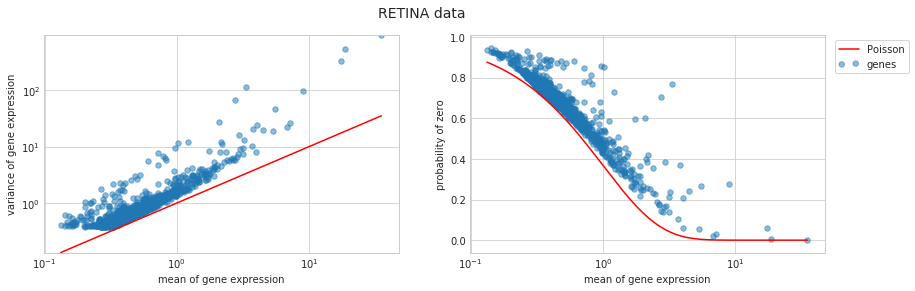

In [9]:
n_cells = X.shape[0]
n_genes = X.shape[1]

genecounts_mean = np.mean(X, axis=0)
genecounts_var = np.var(X, axis=0)

x = np.linspace(genecounts_mean.min(), genecounts_mean.max(), num=100000)
r_ = .1

s = 30
alpha = 0.5

fig = plt.figure(figsize=(14, 4))
ax = plt.subplot(1, 2, 1)
plt.xscale('log')
plt.yscale('log')
plt.scatter(genecounts_mean, genecounts_var, s=s, alpha=alpha)
plt.plot(x, x, color='red')
# plt.plot(x, x + 1/r_ * x**2, color='red')
plt.xlabel('mean of gene expression')
plt.ylabel('variance of gene expression')
plt.ylim(min(genecounts_mean.min(), genecounts_var.min()), max(genecounts_mean.max(), genecounts_var.max()))

# Dropout probability of each gene: number of cells with zero count of that gene / total number of cells
dropout_prob = np.sum(X==0, axis=0) / n_cells

x = np.linspace(genecounts_mean.min(), genecounts_mean.max(), num=100000)
poi_zeros = np.exp(-x)
nb_zeros = (r_/(x + r_))**r_

ax = plt.subplot(1, 2, 2)
plt.xscale('log')
plt.scatter(genecounts_mean, dropout_prob, label='genes', s=s, alpha=alpha)
plt.plot(x, poi_zeros, color='red', label='Poisson')
# plt.plot(x, nb_zeros, color='red', label='NB (r={})'.format(r_))
plt.xlabel('mean of gene expression')
plt.ylabel('probability of zero')
plt.legend(scatterpoints=2, frameon=True, bbox_to_anchor=[1.25, 1.0])

plt.suptitle('RETINA data', fontsize=14)
# plt.savefig('PBMC_Poisson.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Run models
For each model, we need:
* 5 repetitions on the full data set, for clustering benchmarking. 
    - Keep the best run and:
         - perform t-SNE;
         - get m-pCMF and ZINBayes' cell scalings.
* 5-fold cross-validation to compute the held-out data log-likelihood.
* Run on 5 different corrupted full data sets for imputation benchmarking.

(ensure scVI does not separate the data more than we want it to.)

In [10]:
K = 10

## Factor Analysis

In [ ]:
# 5 repetitions on the full data set
fa_full_reps = []

for i in range(1):
    print('Run {}...'.format(i))
    obj = FactorAnalysis(n_components=K)
    fa = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='FA', do_imp=False, log_data=True)
    fa.run(do_silh=True, do_dll=False, do_holl=False, do_batch=True, do_tsne=False, verbose=True)
    
    fa_full_reps.append(fa)
    print('Done.\n')

In [ ]:
fa.asw, fa.ari, fa.nmi, fa.batch_asw

## ZIFA

In [ ]:
# 5 repetitions on the full data set
zifa_full_reps = []

for i in range(1):
    print('Run {}...'.format(i))
    obj = ZIFA(n_components=K)
    zifa = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='ZIFA', log_data=True, do_imp=False)
    zifa.run(max_iter=1000, do_silh=True, max_time=60*60, do_dll=False, do_holl=False, do_tsne=False, 
             do_batch=True, verbose=True)
    
    zifa_full_reps.append(zifa)
    print('Done.\n')
    
sys.__stdout__.write("*** ZIFA full reps finished.\n");

In [ ]:
# 5 corrupted data sets
zifa_imputation = []

for i in range(1):
    print('Run {}...'.format(i))
    obj = ZIFA(n_components=K)
    zifa = ModelWrapper(obj, X, c_train=labels, X_test=None, log_data=True, name='ZIFA', do_imp=True)
    zifa.run(max_time=60*60, max_iter=100, do_silh=False, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    zifa_imputation.append(zifa)
    print('Done.\n')
    
sys.__stdout__.write("*** ZIFA full reps finished.\n");

## pCMF

In [ ]:
# 5 repetitions on the full data set
pcmf_full_reps = []

for i in range(1):
    print('Run {}...'.format(i))
    obj = pCMF(n_components=K)
    pcmf = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='pCMF', log_data=False, do_imp=False)
    pcmf.run(max_iter=500, do_silh=True, do_dll=False, do_holl=False, do_batch=True, do_tsne=False, verbose=True)
    
    pcmf_full_reps.append(pcmf)
    print('Done.\n')
    
sys.__stdout__.write("*** pCMF full reps finished.\n");

In [ ]:
# 5 repetitions on the full data set
pcmf_imputation = []

for i in range(1):
    print('Run {}...'.format(i))
    obj = pCMF(n_components=K)
    pcmf = ModelWrapper(obj, X, c_train=labels, name='pCMF', log_data=False, do_imp=True)
    pcmf.run(max_iter=500, do_silh=False, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    pcmf_imputation.append(pcmf)
    print('Done.\n')

## ZINB-WaVE

In [ ]:
# 5 repetitions on the full data set
zinbwave_full_reps = []

for i in range(1):
    print('Run {}...'.format(i))
    obj = ZINB_WaVE(n_components=K)
    zinbwave = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='ZINB-WaVE', log_data=False, do_imp=False)
    zinbwave.run(do_silh=True, do_dll=False, do_holl=False, do_tsne=False, do_batch=True, verbose=True)
    
    zinbwave_full_reps.append(zinbwave)
    print('Done.\n')
    
sys.__stdout__.write("*** ZINB-WaVE full reps finished.\n");

In [ ]:
# 5 repetitions on the full data set
zinbwave_imputation = []

for i in range(1):
    print('Run {}...'.format(i))
    obj = ZINB_WaVE(n_components=K)
    zinbwave = ModelWrapper(obj, X, c_train=labels, X_test=None, name='ZINB-WaVE', 
                            log_data=False, do_imp=True)
    zinbwave.run(max_iter=1000, do_silh=False, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    zinbwave_imputation.append(zinbwave)
    print('Done.\n')
    
sys.__stdout__.write("*** ZINBWAVE imputation finished.\n");

## scVI

In [ ]:
# 5 repetitions on the full data set
scvi_full_reps = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = scVI(n_components=K, n_hidden=128, n_layers=1, batch_size=128, batches=True, lr=0.0005)
    scvi = ModelWrapper(obj, X, c_train=labels, b_train=b_onehot, name='scVI', do_imp=False)
    scvi.run(max_iter=120, max_time=60*60, do_silh=True, do_dll=False, do_holl=False, 
             do_batch=True, do_tsne=False, verbose=True)
    
    scvi_full_reps.append(scvi)
    print('Done.\n')
    
sys.__stdout__.write("*** scVI full reps finished.\n");

In [ ]:
scvi.asw, scvi.ari, scvi.nmi, scvi.batch_asw

In [ ]:
# 5 corrupted data sets
scvi_imputation = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = scVI(n_components=K, n_hidden=128, batches=False, n_layers=1, batch_size=128)
    scvi = ModelWrapper(obj, X, c_train=labels, X_test=None, name='scVI', do_imp=True)
    scvi.run(max_iter=120, max_time=60*60, do_silh=False, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    scvi_imputation.append(scvi)
    print('Done.\n')
    
sys.__stdout__.write("*** scVI imputation finished.\n");

## m-pCMF

In [ ]:
# 5 repetitions on the full data set
mpcmf_full_reps = []

for i in range(1):
    print('Run {}...'.format(i))
    mpcmf = mpCMF(X, c_train=labels, b_train=b_onehot, n_components=K, scalings=True, sparsity=False, 
                  zero_inflation=True, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=True, batch_correction=True)
    mpcmf.run(max_iter=200, max_time=60*60*2, do_silh=True, do_holl=False, do_dll=False, tol=None,
              do_tsne=False, calc_test=False, verbose=True, calc_silh=True, do_batch=True)
    
    mpcmf_full_reps.append(mpcmf)
    print('Done.\n')
    
sys.__stdout__.write("*** mpcMF full reps finished.\n");

Run 0...
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Considering 2 experimental batches.
Running m-pCMF...


In [162]:
mpcmf_full_reps[0].asw, mpcmf_full_reps[0].ari, mpcmf_full_reps[0].nmi, mpcmf_full_reps[0].batch_asw

(0.21707415351496082,
 0.3306882523552564,
 0.4925895503213444,
 0.02991032372862051)

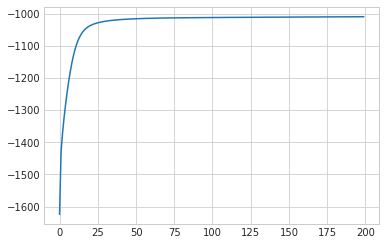

In [170]:
plt.plot(mpcmf.inf.elbo_it)

In [15]:
# 5 repetitions on the full data set
mpcmf_nobatch_full_reps = []

for i in range(1):
    print('Run {}...'.format(i))
    mpcmf = mpCMF(X, c_train=labels, b_train=b_onehot, n_components=K, scalings=True, sparsity=False, 
                  zero_inflation=True, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=True, batch_correction=False)
    mpcmf.run(max_iter=1000, max_time=60*60*2, do_silh=True, do_holl=False, do_dll=False, tol=0.00005,
              do_tsne=False, calc_test=False, verbose=True, calc_silh=False, do_batch=True)
    
    mpcmf_nobatch_full_reps.append(mpcmf)
    print('Done.\n')
    
sys.__stdout__.write("*** mpCMF full reps no batch finished.\n");

Run 0...
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 91/1000. ELBO: -1011.5782263. Improvement: 0.0000491. Elapsed: 0h34m53s
Convergence criterion reached.

Done.
Done.



/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [16]:
mpcmf_nobatch_full_reps[0].asw, mpcmf_nobatch_full_reps[0].ari, mpcmf_nobatch_full_reps[0].nmi, mpcmf_nobatch_full_reps[0].batch_asw

(0.20451800231453543,
 0.275740501739063,
 0.4595254079087821,
 0.04649826606599291)

In [ ]:
# 5 corrupted data sets
mpcmf_imputation = []

for i in range(5):
    print('Run {}...'.format(i))
    mpcmf = mpCMF(X, n_components=K, scalings=True, sparsity=False, 
                  zero_inflation=True, empirical_bayes=False, do_imp=True, name="m-pCMF", minibatch_size=None, 
                  nb=True, batch_correction=False)
    mpcmf.run(max_iter=1000, max_time=60*30, do_silh=False, do_holl=False, do_dll=False, tol=0.00005,
              do_tsne=False, calc_test=False, verbose=True, calc_silh=False)
    
    mpcmf_imputation.append(mpcmf)
    print('Done.\n')
    
sys.__stdout__.write("*** mpCMF imputation finished.\n");

## ZINBayes

In [30]:
# 5 repetitions on the full data set
zinbayes_full_reps = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = ZINBayes(n_components=K, n_mc_samples=5, batch_correction=True)
    zinbayes = ModelWrapper(obj, X, b_train=b_onehot, c_train=labels, name='ZINBayes', do_imp=False)
    zinbayes.run(max_iter=1000, do_silh=True, do_dll=False, do_holl=False, do_tsne=False, do_batch=True, 
                 verbose=True)
    
    zinbayes_full_reps.append(zinbayes)
    print('Done.\n')
    
sys.__stdout__.write("*** ZINBayes full reps finished.\n");

Run 0...
Considering zero-inflation.
Performing batch correction.
Considering cell-specific scalings.
Running ZINBayes...
1000/1000 [100%] ██████████████████████████████ Elapsed: 6702s | Loss: 980.936


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 1...
Considering zero-inflation.
Performing batch correction.
Considering cell-specific scalings.
Running ZINBayes...
1000/1000 [100%] ██████████████████████████████ Elapsed: 6698s | Loss: 972.715


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 2...
Considering zero-inflation.
Performing batch correction.
Considering cell-specific scalings.
Running ZINBayes...
1000/1000 [100%] ██████████████████████████████ Elapsed: 6684s | Loss: 968.845


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 3...
Considering zero-inflation.
Performing batch correction.
Considering cell-specific scalings.
Running ZINBayes...
1000/1000 [100%] ██████████████████████████████ Elapsed: 6644s | Loss: 971.806


/home/ubuntu/thesis/venv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Done.
Done.

Run 4...
Considering zero-inflation.
Performing batch correction.
Considering cell-specific scalings.
Running ZINBayes...
  50/1000 [  5%] █                              ETA: 6609s | Loss: 1417.316

KeyboardInterrupt: 

In [ ]:
plt.plot(zinbayes.model_inst.loss_dict['t_loss'][:])

In [31]:
zinbayes.asw, zinbayes.ari, zinbayes.nmi, zinbayes.batch_asw

(None, None, None, None)

In [34]:
# 5 repetitions on the full data set
zinbayes_nobatch_full_reps = []

for i in range(1):
    print('Run {}...'.format(i))
    obj = ZINBayes(n_components=K, n_mc_samples=5, batch_correction=False)
    zinbayes = ModelWrapper(obj, X, b_train=b_onehot, c_train=labels, name='ZINBayes', do_imp=False)
    zinbayes.run(max_iter=1000, do_silh=True, do_dll=False, do_holl=False, do_tsne=False, do_batch=True,
                 verbose=True)
    
    zinbayes_nobatch_full_reps.append(zinbayes)
    print('Done.\n')
    
sys.__stdout__.write("*** ZINBayes full reps no batch finished.\n");

Run 0...
Considering zero-inflation.
Considering cell-specific scalings.
Running ZINBayes...


KeyboardInterrupt: 

In [ ]:
zinbayes.asw, zinbayes.ari, zinbayes.nmi, zinbayes.batch_asw

In [ ]:
# 5 repetitions on the full data set
zinbayes_imputation = []

for i in range(5):
    print('Run {}...'.format(i))
    obj = ZINBayes(n_components=K, n_mc_samples=5, batch_correction=False)
    zinbayes = ModelWrapper(obj, X, name='ZINBayes', do_imp=True)
    zinbayes.run(max_iter=1000, do_silh=False, do_dll=False, do_holl=False, do_tsne=False, verbose=True)
    
    zinbayes_imputation.append(zinbayes)
    print('Done.\n')
    
sys.__stdout__.write("*** ZINBayes imputation finished.\n");

# Plot results

In [ ]:
colors = sns.color_palette("Set1", 10, desat=.7) # this is a list of 10 colors

# We must choose what color to assign to each model
model_list_clustering = [mpcmf_full_reps, zinbayes_full_reps, zinbwave_full_reps, scvi_full_reps, pcmf_full_reps, zifa_full_reps, fa_full_reps]
# model_list_ll = [mpcmf_cv, zinbayes_cv, zinbwave_cv, scvi_cv, zifa_cv, fa_cv]
model_list_imp = [mpcmf_imputation, zinbayes_imputation, zinbwave_imputation, scvi_imputation, pcmf_imputation, zifa_imputation]

# Colors
color_list_clustering = [colors[0], colors[1], colors[2], colors[4], colors[3], colors[5], colors[6]]
hatch_list_clustering = ['//', '//', None, None, None, None, None]
color_list_ll = [colors[0], colors[1], colors[2], colors[4], colors[5], colors[6]]
hatch_list_ll = ['//', '//', None, None, None, None]
color_list_imp = [colors[0], colors[1], colors[2], colors[4], colors[3], colors[5]]
hatch_list_imp = ['//', '//', None, None, None, None, None]

## Latent space clustering

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax,_,_  = plot_utils.clustering_cv(model_list_clustering, colors=color_list_clustering, show_legend=False, ylim=[0, 1],
                            title=None, ax=ax, box=False, hatches=None);
ax.figure.savefig('RETINA_clustering_bars.png', dpi=300, bbox_inches='tight')

In [137]:
mpcmf.est_U = mpcmf.inf.estimate_U()

In [164]:
mpcmf.do_tsne()

In [35]:
model_list_2d = [mpcmf_full_reps[0], zinbayes_full_reps[0], fa_full_reps[0]]

In [152]:
model_list_2d[0].nmi

0.4284697635567544

In [151]:
mpcmf.nmi

0.4502958879341829

In [36]:
for model in model_list_2d:
    model.do_tsne()

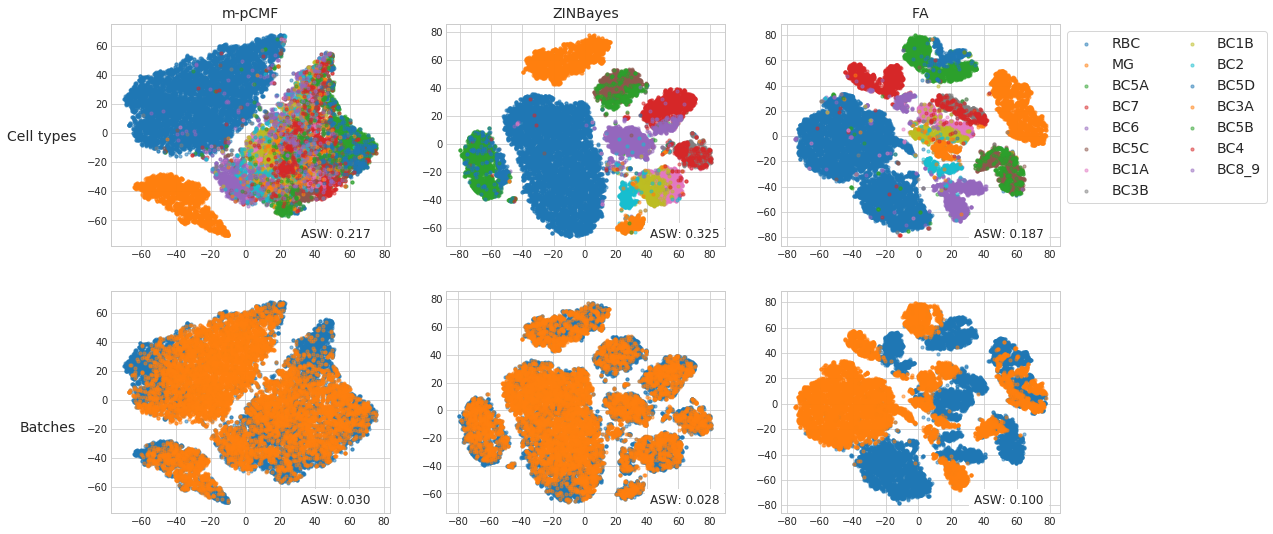

In [173]:
fig = plt.figure(figsize=(17, 9))

plt.figtext(0.04, .7, 'Cell types', fontsize=14)
plt.figtext(0.05, .25, 'Batches', fontsize=14)

ax = plt.subplot(2, 3, 1)
plot_utils.plot_tsne(mpcmf.proj_2d[:], labels[:], ax=ax, title=mpcmf.name, s=10)
plt.figtext(0.28, .55, 'ASW: {:.3f}'.format(mpcmf.asw), fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

ax = plt.subplot(2, 3, 2)
plot_utils.plot_tsne(model_list_2d[1].proj_2d, labels, ax=ax, title=model_list_2d[1].name, s=10)
plt.figtext(0.565, .55, 'ASW: {:.3f}'.format(model_list_2d[1].asw), fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

ax = plt.subplot(2, 3, 3)
plot_utils.plot_tsne(model_list_2d[2].proj_2d, labels, ax=ax, title=model_list_2d[2].name, s=10, labels=clusters, legend=True, ncol=2, bbox_to_anchor=[1., 1.])
plt.figtext(0.83, .55, 'ASW: {:.3f}'.format(model_list_2d[2].asw), fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

ax = plt.subplot(2, 3, 4)
plot_utils.plot_tsne(mpcmf.proj_2d, b_onehot[:, 0], ax=ax, s=10)
plt.figtext(0.28, .14, 'ASW: {:.3f}'.format(mpcmf.batch_asw), fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

ax = plt.subplot(2, 3, 5)
plot_utils.plot_tsne(model_list_2d[1].proj_2d, b_onehot[:, 0], ax=ax, s=10)
plt.figtext(0.565, .14, 'ASW: {:.3f}'.format(model_list_2d[1].batch_asw), fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

ax = plt.subplot(2, 3, 6)
plot_utils.plot_tsne(model_list_2d[2].proj_2d, b_onehot[:, 0], ax=ax, s=10)
plt.figtext(0.83, .14, 'ASW: {:.3f}'.format(model_list_2d[2].batch_asw), fontsize=12, bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

plt.savefig('RETINA_2d_clustering_batch.png', dpi=300, bbox_inches='tight')
sys.__stdout__.write("*** Saved clustering batch 2d image to file.\n");

In [ ]:
PLOT DETECTION RATE BOX PLOTS FOR EACH BATCH!

In [ ]:
fig = plt.figure(figsize=(17, 8))
ax = plt.axes()
plot_utils.plot_2d(model_list_2d, labels, nrows=1, ncols=3, ax=ax, 
                          labels=clusters, legend=True, bbox_to_anchor=[1.2, 1.], titles=True)

In [ ]:
fig = plt.figure(figsize=(17, 8))
ax = plt.axes()
plot_utils.plot_2d(model_list_2d, b_onehot[:, 0], nrows=1, ncols=3, ax=ax, 
                          labels=clusters, legend=True, bbox_to_anchor=[1.2, 1.], titles=True, filename='RETINA_2d_all_batch.png')

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes()
plot_utils.plot_2d([model_list_2d[0]], labels, nrows=1, ncols=1, ax=ax, 
                          labels=clusters, legend=True, bbox_to_anchor=[1., 1.], titles=True, filename='RETINA_2d_mpcmf.png')

## Held-out data log-likelihood

In [ ]:
plt.figure(figsize=(10, 6))
ax = plt.axes()
ax = plot_utils.loglikelihood_cv(model_list_ll, colors=color_list_ll, show_legend=True, hatches=None,
                            title=None, ax=ax, box=False);
ax.figure.savefig('RETINA_ll_legend.png', dpi=300, bbox_inches='tight')

## Imputation error

In [ ]:
plt.figure(figsize=(5, 6))
ax = plt.axes()
ax = plot_utils.imputationerr_boxplot(model_list_imp, colors=color_list_imp, 
                                 show_legend=True, ax=ax, box=False, hatches=None);
plt.ylim(0, 1.5);
ax.figure.savefig('RETINA_imp_legend.png', dpi=300, bbox_inches='tight')

## Technical variability

In [ ]:
est_l = zinbayes.model_inst.est_L
log_library_size = np.log(np.sum(X_train, axis=1))

In [ ]:
plt.scatter(np.log(est_l).ravel(), log_library_size, alpha=0.5, s=30)
plt.ylabel('log-library size')
plt.xlabel('log-cell scaling')
plt.title('All cell types')
plt.show()

ctype = 6
plt.scatter(np.log(est_l)[c_train==ctype].ravel(), log_library_size[c_train==ctype], alpha=0.5, s=30)
plt.ylabel('log-library size')
plt.xlabel('log-cell scaling')
plt.title('{}: correlation={:.4f}'.format(y_collapsed_names[ctype], pearsonr(log_library_size[c_train==ctype], np.log(est_l)[c_train==ctype].ravel())[0]))
plt.show()

## Batch correction

## Gene groups

## Differential Expression